#  Прогнозирование заказов такси

## 1. Подготовка данных

In [1]:
#импорты библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb
from catboost import CatBoostRegressor
from prophet import Prophet

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
import scipy.stats as stats

warnings.filterwarnings("ignore")

In [2]:
#Загрузка данных в переменную df
try:
    df = pd.read_csv('/datasets/taxi.csv', index_col=0, parse_dates=[0])
except:
    df = pd.read_csv('C:/Users/Mi/Desktop/taxi.csv', index_col=0, parse_dates=[0])
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
#проверим, все ли даты идут по возрастанию
df.index.is_monotonic

True

Все даты идут по возрастанию, можем ресемплировать данные их по часу для нашей работы

In [4]:
#выполним ресемплирование по одному часу
df = df.resample('1H').sum()

## 2. Анализ

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


В датасете 4416 обьектов и всего один признак - количество заказов.

In [6]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


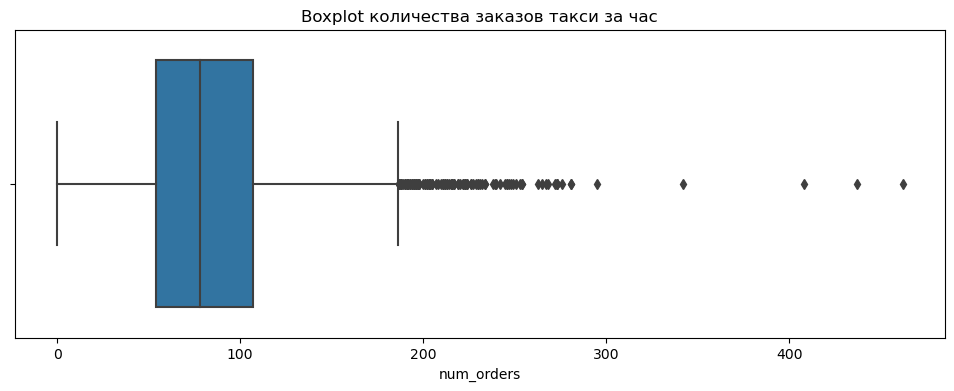

In [7]:
#построим ящик с усами, чтобы оценить количество выбросов в данных
plt.rcParams["figure.figsize"] = (12, 4)
ax = sns.boxplot(x=df["num_orders"])
ax.set_title('Boxplot количества заказов такси за час');

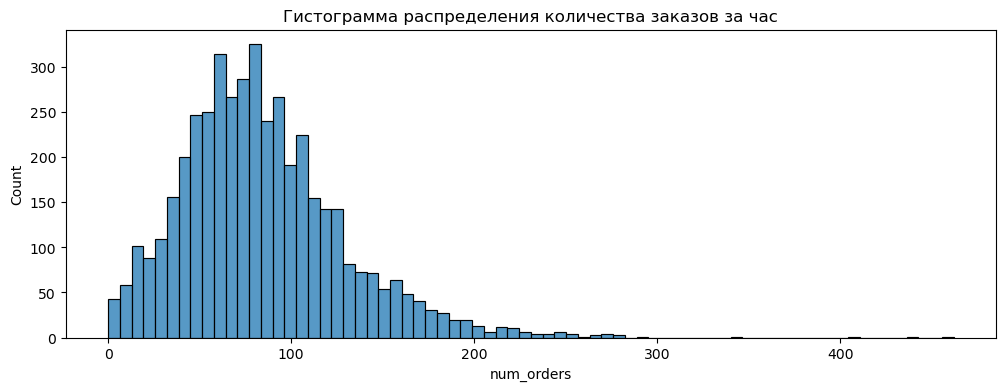

In [8]:
#также построим гистограмму респределений
ax=sns.histplot(data=df, x="num_orders")
ax.set_title('Гистограмма распределения количества заказов за час');

В датасете присутствуют экстремально высокие значения и значения равные нулю.
Наличие нулевого значения количества заказов не актуально в данной работе, поэтому удалим данный выброс.

Удаление высоких и низких значений - шумов, может ухудшить нахождение моделями сезонных составляющих, поэтому данные выбросы обрабатывать не будем.

In [9]:
df = df.query('num_orders > 0')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4415 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4415 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


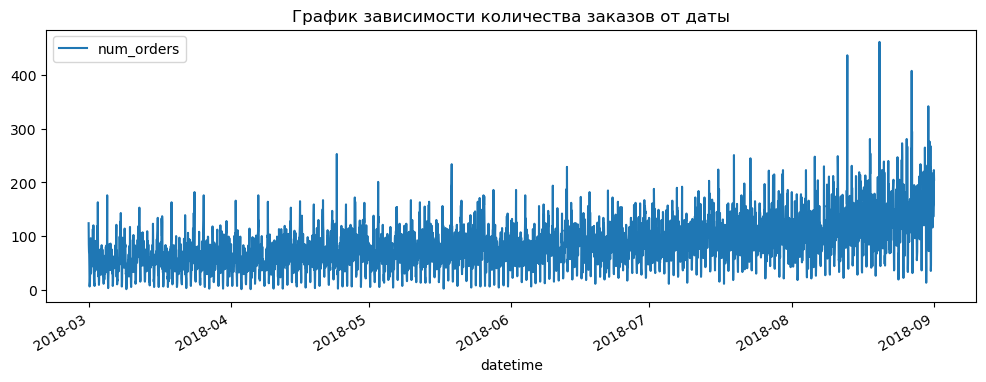

In [11]:
#построим график заказов от времени
df.plot(title = 'График зависимости количества заказов от даты');

Все данные с марта по сентябрь 2018 года.
Похоже, что есть тренд на увеличение количества заказов в сервисе в целом. Нужно посмотреть на сглаженные данные чтобы сказать наверняка.

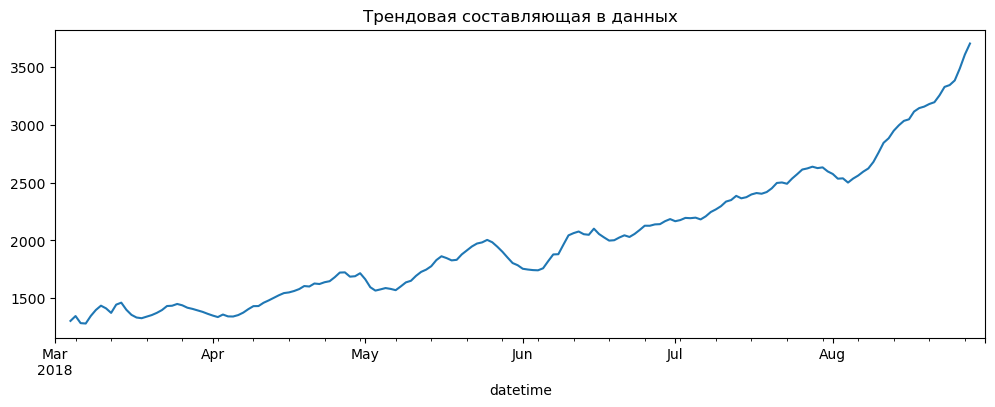

In [12]:
#рассмотрим тренд в данных
seasonal_decompose(df.resample('1D').sum()).trend.plot(title='Трендовая составляющая в данных');

Прослеживается тренд на увеличение количества заказов в данном сервисе втечение всего периода.

Так как данные всего за один неполный год проследить месячную сезонность по таким данным невозможно.

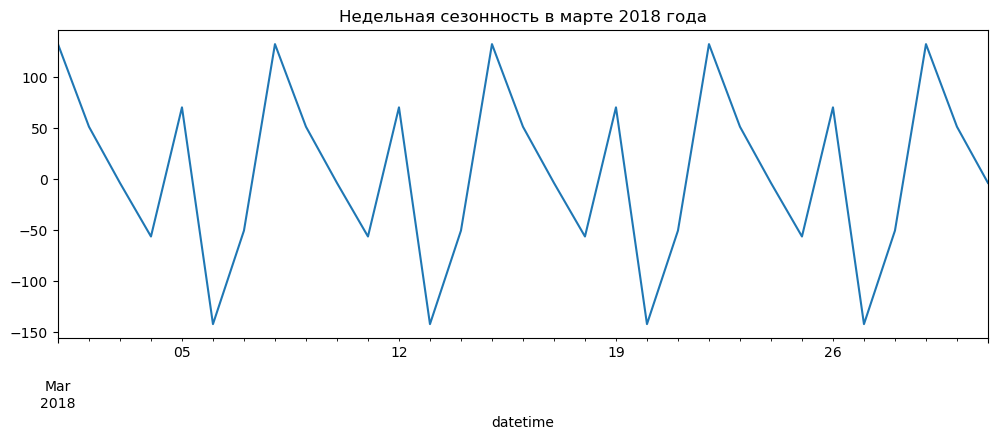

In [13]:
#рассмотрим сезонность в данных за какой-нибудь месяц(к примеру март 2018 года)
seasonal_decompose(df['2018-03-01':'2018-03-31'].resample('1D').sum()).seasonal\
.plot(title='Недельная сезонность в марте 2018 года');

Очевидная недельная сезонная составляющая в данных. В рабочие дни люди чаще пользуются услугами такси, в выходные дни показатель минимальный.

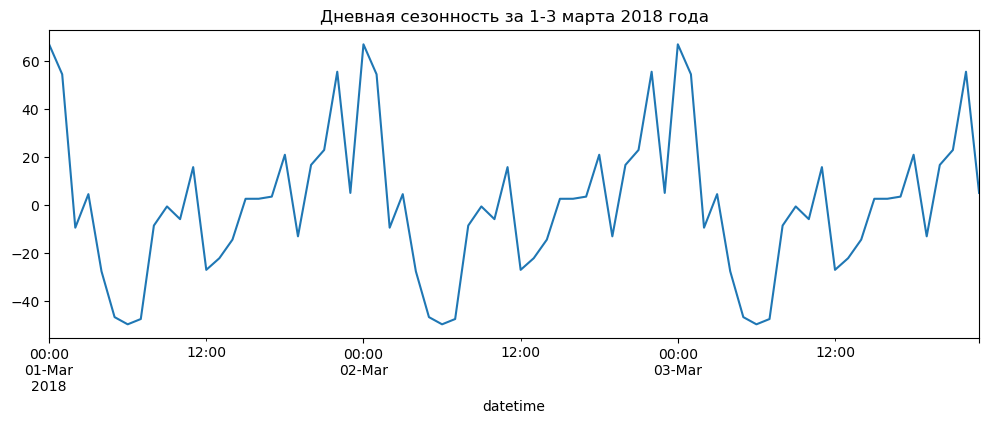

In [14]:
#рассмотрим сезонность в данных за 2 дня (1-3 марта 2018 года)
seasonal_decompose(df['2018-03-01':'2018-03-3'].resample('1H').sum()).seasonal\
.plot(title='Дневная сезонность за 1-3 марта 2018 года');

Также прослеживается дневная сезонность в данных - больше всего люди пользуются такси в районе полуночи. Меньше всего - поздней ночью и в полдень.

На основании анализа сезонностей в данных можем добавить признаки, которые помогут нам при обучении моделей.

## 3. Подготовка данных

### 3.1 Создание новых признаков

In [15]:
#создание календарных признаков
df['day_of_week'] = df.index.dayofweek
df['hour'] = df.index.hour

Учитывая, что мы наблюдаем дневную и недельную сезонность, построим признаки на основании сдвига по часам (до суток) и скользящего среднего (1 дня).

In [16]:
#функция создания новых признаков на основании сдвигов и скользящего среднего
def new_features(df, sh, roll):
    data = df.copy()
    for i in range(sh):
        data[f'lag_{i + 1}'] = data['num_orders'].shift(i + 1)
        
    data['rolling_mean_day'] = data['lag_1'].rolling(roll).mean()
    data = data.dropna()
    return data

In [17]:
df_new = new_features(df, 24, 24)
df_new.head()

,num_orders,day_of_week,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean_day
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,4,0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,56.833333
2018-03-02 01:00:00,120,4,1,90.0,58.0,113.0,66.0,61.0,45.0,73.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,55.416667
2018-03-02 02:00:00,75,4,2,120.0,90.0,58.0,113.0,66.0,61.0,45.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,56.875000
2018-03-02 03:00:00,64,4,3,75.0,120.0,90.0,58.0,113.0,66.0,61.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,57.041667
2018-03-02 04:00:00,20,4,4,64.0,75.0,120.0,90.0,58.0,113.0,66.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,56.958333


In [18]:
#удалим впропуски, которые появились в процессе создания признаков
df_new = df_new.dropna()

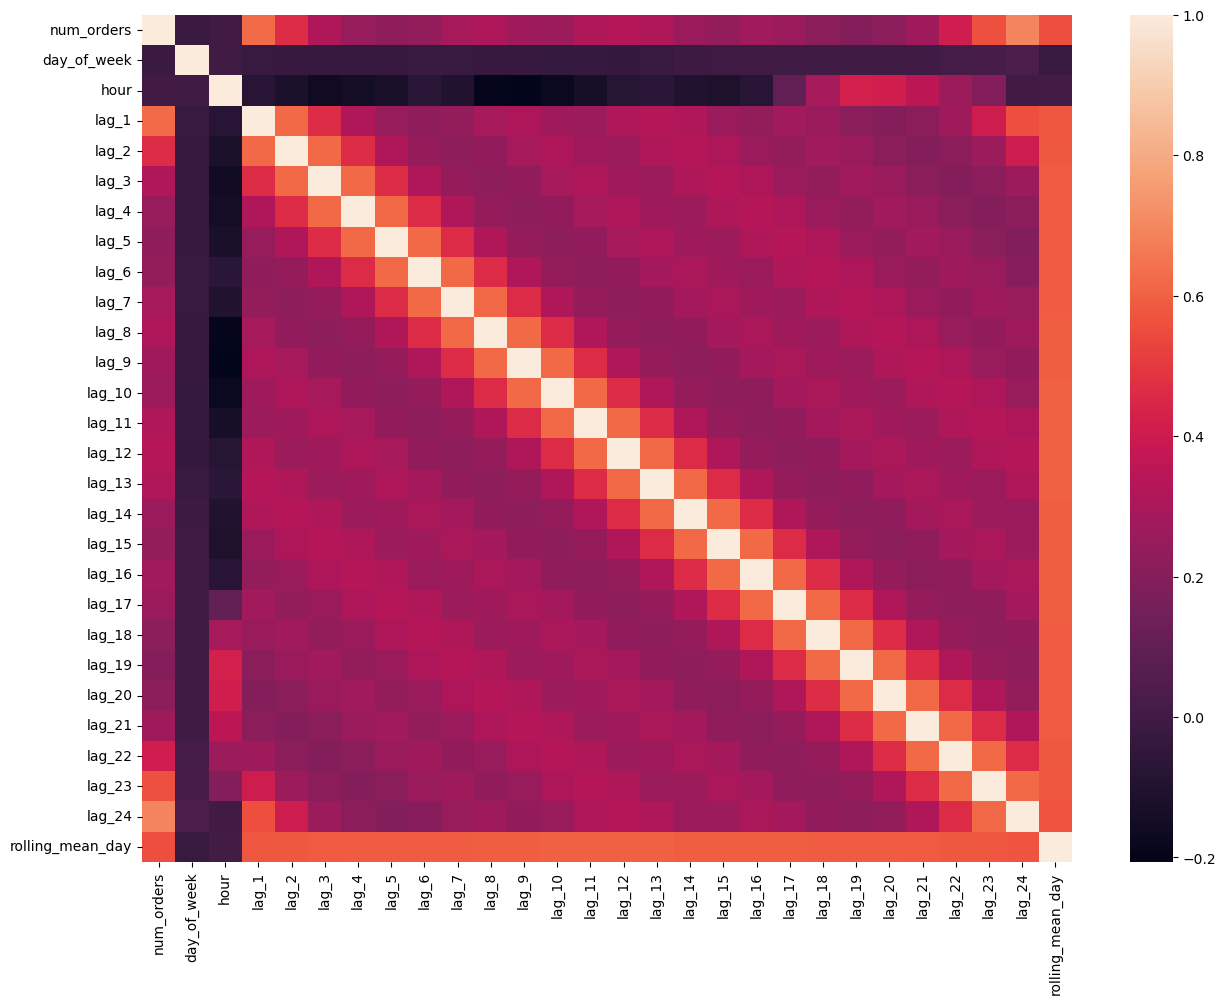

In [19]:
#heatmap корреляций признаков
plt.rcParams["figure.figsize"] = (15, 11)
sns.heatmap(df_new.corr());

In [20]:
#конечная размерность данных
df_new.shape

(4391, 28)

### 3.2 Разделениe выборок на обучающую и тестовую

In [21]:
#выделим признаки и таргет
X = df_new.drop('num_orders', axis=1)
y = df_new.num_orders

In [22]:
#Разделим выборки на обучающую и тестовую в соотношении 9:1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

## 4. Обучение моделей

In [23]:
#Метрика RMSE
RMSE = lambda x, y: mean_squared_error(x, y) ** 0.5

### 4.1 Базовая модель

In [24]:
#Построим базовую модель для проверки наших моделей на адекватность

dummy_model = pd.Series(y_train.mean(), index=y_test.index)
print('RMSE базовой модели =', RMSE(y_test, dummy_model))

RMSE базовой модели = 84.6733559922292


### 4.2 Линейные модели

In [25]:
#Модель линейной регрессии
tscv = TimeSeriesSplit(n_splits=3).split(X_train)
lin = LinearRegression(n_jobs=-1)
params = {}
lin_Grid = GridSearchCV(estimator=lin, cv=tscv, param_grid=params, scoring='neg_root_mean_squared_error')
lin_Grid.fit(X_train, y_train)

print('RMSE кросс-валидации для линейной регрессии', -lin_Grid.best_score_)

RMSE кросс-валидации для линейной регрессии 27.823825653087955


In [26]:
#Ridge
tscv = TimeSeriesSplit(n_splits=3).split(X_train)
ridge = Ridge(random_state=777)
params = {'alpha': [0.01, 0.1, 0.5, 1.0, 3, 5, 10]}
ridge_Grid = GridSearchCV(estimator=ridge, cv=tscv, param_grid=params, scoring='neg_root_mean_squared_error')
ridge_Grid.fit(X_train, y_train)
print('RMSE кросс-валидации для Ridge регрессии', -ridge_Grid.best_score_)
print('Лучшие параметры для Ridge регрессии', ridge_Grid.best_params_)

RMSE кросс-валидации для Ridge регрессии 27.82297117679313
Лучшие параметры для Ridge регрессии {'alpha': 10}


In [27]:
#Lasso
tscv = TimeSeriesSplit(n_splits=3).split(X_train)
lasso = Lasso(random_state=777)
params = {'alpha': [0.01, 0.1, 0.5, 1.0, 3, 5, 10]}
lasso_Grid = GridSearchCV(estimator=lasso, cv=tscv, param_grid=params, scoring='neg_root_mean_squared_error')
lasso_Grid.fit(X_train, y_train)
print('RMSE кросс-валидации для Lasso регрессии', -lasso_Grid.best_score_)
print('Лучшие параметры для Lasso регрессии', lasso_Grid.best_params_)

RMSE кросс-валидации для Lasso регрессии 27.72896054821258
Лучшие параметры для Lasso регрессии {'alpha': 5}


Из линейных моделей лучше всего себя показала модель с Lasso ругуляризацией(alpha=5). 
Значение RMSE линейных моделей около 28

### 4.3 RandomForest

In [28]:
%%time
#Модель случайного леса
tscv = TimeSeriesSplit(n_splits=3).split(X_train)
rf = RandomForestRegressor(n_jobs=-1, random_state=777)
params = {'max_depth': [4, 8, 12, 16, 20, 30],
         'n_estimators': [50, 100, 150, 200, 400, 600],
         'min_samples_leaf': [1, 4, 8]}
rf_Grid = GridSearchCV(estimator=rf, cv=tscv, param_grid=params, scoring='neg_root_mean_squared_error')
rf_Grid.fit(X_train, y_train)

CPU times: total: 1min 59s
Wall time: 5min


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x000002117996EAB0>,
             estimator=RandomForestRegressor(n_jobs=-1, random_state=777),
             param_grid={'max_depth': [4, 8, 12, 16, 20, 30],
                         'min_samples_leaf': [1, 4, 8],
                         'n_estimators': [50, 100, 150, 200, 400, 600]},
             scoring='neg_root_mean_squared_error')

In [29]:
%%time
print('RMSE кросс-валидации для линейной регрессии', -rf_Grid.best_score_)
print('Лучшие параметры случайного леса', rf_Grid.best_params_)

RMSE кросс-валидации для линейной регрессии 26.735084264838957
Лучшие параметры случайного леса {'max_depth': 30, 'min_samples_leaf': 1, 'n_estimators': 400}
CPU times: total: 0 ns
Wall time: 0 ns


### 4.4 Градиентные бустинги

#### 4.4.1 xgboost

In [30]:
%%time
#XGboost
tscv = TimeSeriesSplit(n_splits=3).split(X_train)
xg = xgb.XGBRegressor(n_jobs=-1, random_state=777, verbosity=0)
params = {'max_depth': [4, 5, 6],
         'n_estimators': [100, 500, 1000],
         'learning_rate':[0.3, 0.1, 0.03],
          'booster': ['gbtree', 'gblinear'],
          'alpha': [0.1, 0.5, 1]
         }
xg_Grid = GridSearchCV(estimator=xg, cv=tscv, param_grid=params, scoring='neg_root_mean_squared_error')
xg_Grid.fit(X_train, y_train)

CPU times: total: 52min 48s
Wall time: 3min 30s


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x000002117A1721F0>,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_ty...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=-1, num_parallel_tree=None,
                                    predictor=None, random_state=777, ...),
             param_grid={'alpha': [0.1, 0.5, 1],
                         'booster': ['gbtree', 'gblinear'],
                         'learning_rate': [0.3, 0.1, 0.03],
                         'max_depth': [4, 5, 6],
                         'n_estimators': [100, 500, 1000]},
             scoring='neg_root_mean_squared_error')

In [31]:
%%time
print('RMSE кросс-валидации для XGBoost', -xg_Grid.best_score_)
print('Лучшие параметры для XGBoost', xg_Grid.best_params_)

RMSE кросс-валидации для XGBoost 26.028032838860256
Лучшие параметры для XGBoost {'alpha': 0.5, 'booster': 'gbtree', 'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 500}
CPU times: total: 0 ns
Wall time: 0 ns


#### 4.4.2 catboost

In [57]:
%%time
#XGboost
tscv = TimeSeriesSplit(n_splits=3).split(X_train)
cat = CatBoostRegressor(random_state=777, verbose=0)
params = {'depth': [4, 6, 8],
          'iterations': [100, 500, 1000, 2000],
          'learning_rate':[0.3, 0.1, 0.03],
          'min_child_samples': [1, 4, 8]
         }
cat_Grid = GridSearchCV(estimator=cat, cv=tscv, param_grid=params, scoring='neg_root_mean_squared_error', n_jobs=-1)
cat_Grid.fit(X_train, y_train)

CPU times: total: 11.7 s
Wall time: 27min 22s


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x000002116778D930>,
             estimator=<catboost.core.CatBoostRegressor object at 0x000002117BDB8610>,
             n_jobs=-1,
             param_grid={'depth': [4, 6, 8],
                         'iterations': [100, 500, 1000, 2000],
                         'l2_leaf_reg': [0.5, 1, 5],
                         'learning_rate': [0.3, 0.1, 0.03],
                         'min_child_samples': [1, 4, 8]},
             scoring='neg_root_mean_squared_error')

In [58]:
%%time
print('RMSE кросс-валидации для catboost', -cat_Grid.best_score_)
print('Лучшие параметры для catboost', cat_Grid.best_params_)

RMSE кросс-валидации для catboost 25.56555057748874
Лучшие параметры для catboost {'depth': 6, 'iterations': 2000, 'l2_leaf_reg': 1, 'learning_rate': 0.03, 'min_child_samples': 1}
CPU times: total: 0 ns
Wall time: 0 ns


### 4.5 Prophet

In [34]:
#создадим новый датасет DF_propthet(только с временем и количеством заказов)
DF_propthet = df.copy().reset_index()[['datetime', 'num_orders']]
DF_propthet.columns = ['ds', 'y']
DF_propthet.head()

,ds,y
0,2018-03-01 00:00:00,124
1,2018-03-01 01:00:00,85
2,2018-03-01 02:00:00,71
3,2018-03-01 03:00:00,66
4,2018-03-01 04:00:00,43


In [35]:
#отделим 10% последних данных
df_train, df_test = train_test_split(DF_propthet, test_size=0.1, random_state=777, shuffle=False)

In [36]:
#обучим Prophet на обучающей выборке
m = Prophet()
m.fit(df_train)

#предскажем тестовую выборку
forecast = m.predict(df_test)
forecast.head()

10:19:27 - cmdstanpy - INFO - Chain [1] start processing
10:19:28 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-08-13 14:00:00,115.25054,83.053086,147.498254,115.25054,115.25054,-0.195085,-0.195085,-0.195085,-5.331014,-5.331014,-5.331014,5.135929,5.135929,5.135929,0.0,0.0,0.0,115.055454
1,2018-08-13 15:00:00,115.27414,99.219002,161.281959,115.27414,115.27414,14.982206,14.982206,14.982206,10.781111,10.781111,10.781111,4.201094,4.201094,4.201094,0.0,0.0,0.0,130.256345
2,2018-08-13 16:00:00,115.29774,104.281271,169.201930,115.29774,115.29774,19.897588,19.897588,19.897588,16.693968,16.693968,16.693968,3.203620,3.203620,3.203620,0.0,0.0,0.0,135.195327
3,2018-08-13 17:00:00,115.32134,91.685177,157.072211,115.32134,115.32134,10.377368,10.377368,10.377368,8.222809,8.222809,8.222809,2.154560,2.154560,2.154560,0.0,0.0,0.0,125.698708
4,2018-08-13 18:00:00,115.34494,79.843502,142.706560,115.34494,115.34494,-4.630314,-4.630314,-4.630314,-5.695858,-5.695858,-5.695858,1.065544,1.065544,1.065544,0.0,0.0,0.0,110.714626


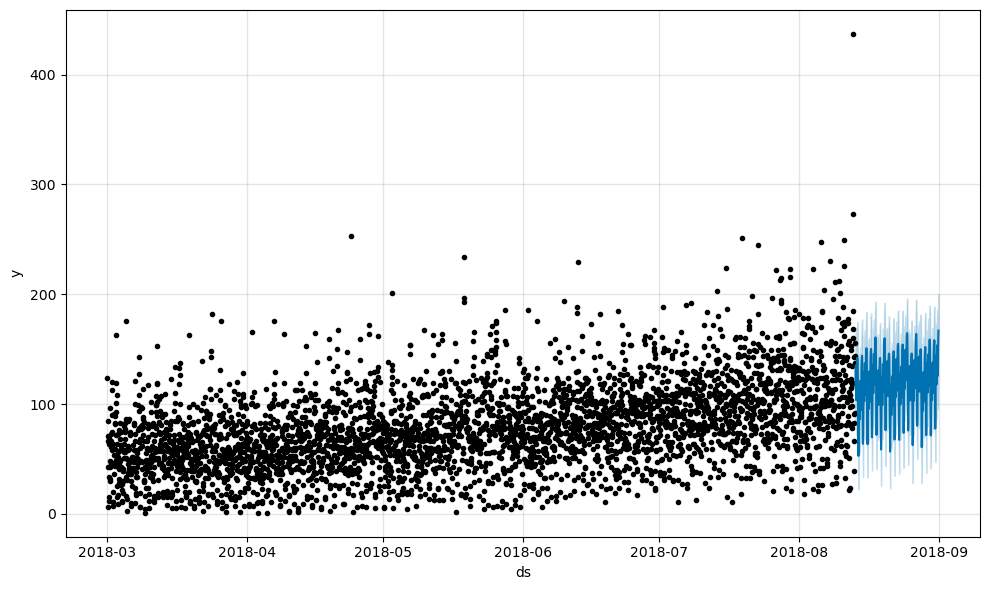

In [37]:
#визуализация предсказания Propthet
m.plot(forecast, uncertainty=True)
plt.rcParams["figure.figsize"] = (15,5)

Мы видим, что Prophet правильно предсказал тренд, но шумов меньше, чем в реальных данных.

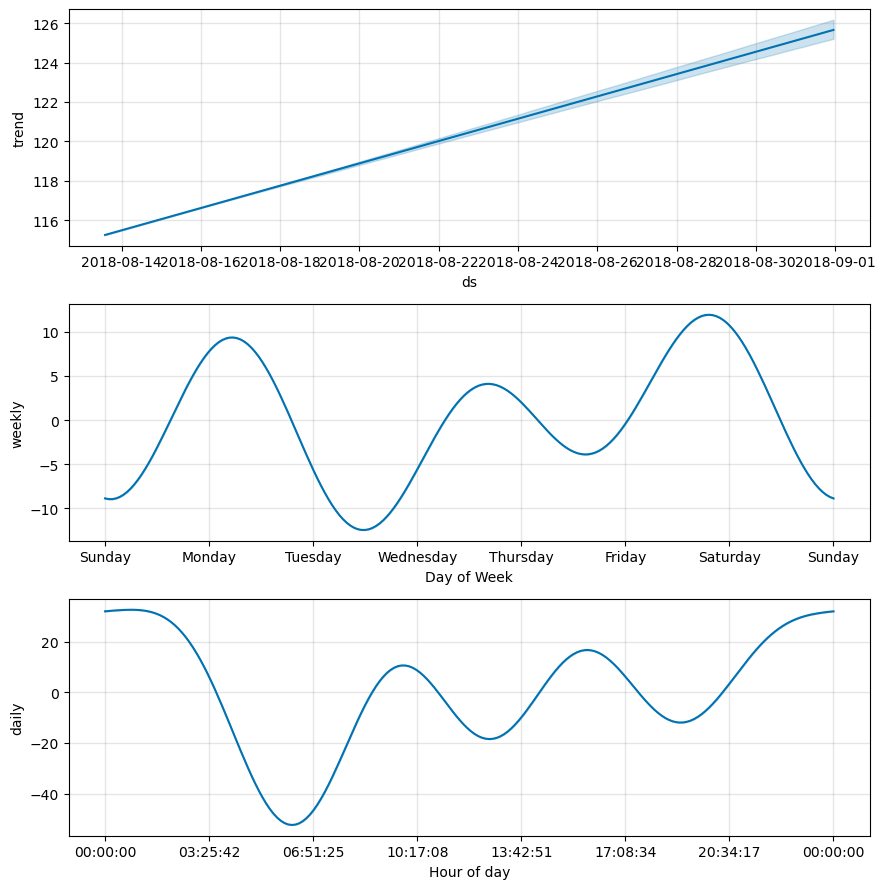

In [38]:
#составляющие предсказания
m.plot_components(forecast)
plt.rcParams["figure.figsize"] = (15,4)

Мы видим те же составляющие - тренд и сезонность, которые отметили ранее

In [39]:
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(DF_propthet.set_index('ds'))
cmp_df.tail()

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2018-08-31 19:00:00,125.569822,95.378022,158.179755,136
2018-08-31 20:00:00,132.683089,100.973867,164.283151,154
2018-08-31 21:00:00,147.575237,115.552369,180.323495,159
2018-08-31 22:00:00,160.558341,130.781438,191.990948,223
2018-08-31 23:00:00,166.826531,135.761074,199.842923,205


In [40]:
print('RMSE', RMSE(cmp_df['y'], cmp_df['yhat']))

RMSE 48.256401739810336


Значение метрики качества ниже, чем у рассмотренных выше моделей машинного обучения.

Также попробуем сделать преобразования Бокса-Кокса для улучшения предсказаний.

In [41]:
#зададим функцию преобразования Бокса-Кокса
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

In [42]:
#сделаем копию нашей обучающей выборки, и преобразуем 'y' методом Бокса-Кокса
train_df2 = df_train.copy()
train_df2['y'], lmbda_prophet = stats.boxcox(train_df2['y'])

#обучим нашу выборку и сделаем предсказание
m2 = Prophet()
m2.fit(train_df2)

forecast2 = m2.predict(df_test)
forecast2['yhat'] = invboxcox(forecast2.yhat, lmbda_prophet)

cmp_df2 = forecast2.set_index('ds')[['yhat']].join(DF_propthet.set_index('ds'))

print('RMSE', RMSE(cmp_df2['y'], cmp_df2['yhat']))

10:19:29 - cmdstanpy - INFO - Chain [1] start processing
10:19:29 - cmdstanpy - INFO - Chain [1] done processing


RMSE 47.99912011743459


Значение метрики качества немного улучшилось.

### 4.6 SARIMA

In [43]:
DF_arima = df.copy().reset_index()[['datetime', 'num_orders']]
DF_arima.columns = ['date', 'value']
DF_arima.head()

,date,value
0,2018-03-01 00:00:00,124
1,2018-03-01 01:00:00,85
2,2018-03-01 02:00:00,71
3,2018-03-01 03:00:00,66
4,2018-03-01 04:00:00,43


Для определения параметров модели воспользуемся расширенным тестом Дики-Фуллера, который может помочь определить, является ли временной ряд стационарным. 

In [44]:
# Тест Дики-Фуллера на стационарность
ad_fuller_result = adfuller(DF_arima['value'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -3.0751401525105035
p-value: 0.028448470934702683


Так как p-value менее 0.05 можно отвергнуть нулевую гипотезу о нестационарности - смещение производить не будем.

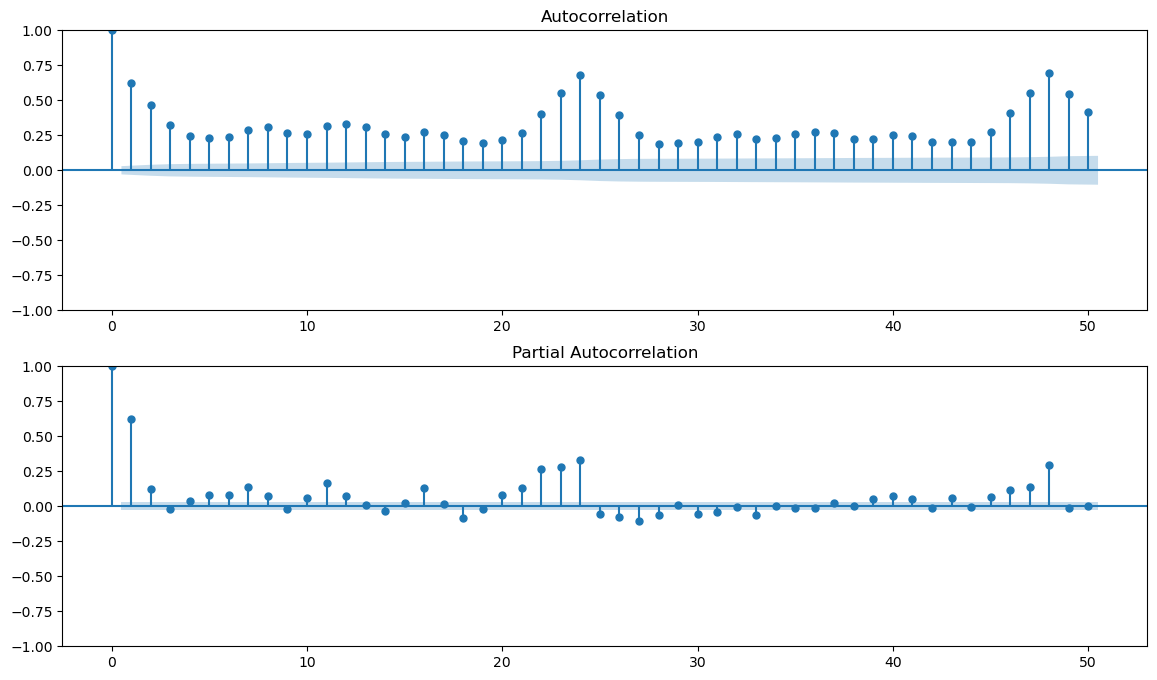

In [45]:
#ACF и FACP графики
fig = plt.figure(figsize=(14,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(DF_arima['value'].dropna(),lags=50,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(DF_arima['value'].dropna(),lags=50,ax=ax2)

In [46]:
#отделим 10% последних данных
ARIMA_train, ARIMA_test = train_test_split(DF_arima, test_size=0.1, random_state=777, shuffle=False)
start = len(ARIMA_train)
end = len(ARIMA_train) + len(ARIMA_test) - 1

In [47]:
#обучим модель
best_model = SARIMAX(ARIMA_train['value'], order=(2, 0, 2), seasonal_order=(2, 0, 2, 24)).fit(dis=-1)
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              value   No. Observations:                 3973
Model:             SARIMAX(2, 0, 2)x(2, 0, 2, 24)   Log Likelihood              -17961.762
Date:                            Thu, 12 Oct 2023   AIC                          35941.524
Time:                                    10:21:59   BIC                          35998.110
Sample:                                         0   HQIC                         35961.589
                                           - 3973                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8698      0.014    137.864      0.000       1.843       1.896
ar.L2         -0.8759      0.012   

In [48]:
predictions = best_model.predict(start=start, end=end, dynamic=False, typ='levels')

In [49]:
print('RMSE', RMSE(ARIMA_test['value'], predictions))

RMSE 51.247818585899665


Метрика качества оказалась хуже других моделей, возможно вследствие специфики данного набора данных. Можно попробовать подобрать гиперпараметры, но это я оставлю на доработку.

**Выводы**:
1. Выборка была поделена на обучающую и тестовую
2. Модели машинного обучения были обучены и протестированы методом кросс-валидации с использованием TimeSeriesSplit деления по фолдам.
3. Были протестированы forecast модели Propthet и Sarima.
4. Была отобрана модель с лучшей метрикой RMSE, лучшая метрика была получена с помощью catboost регрессора, RMSE составило 25.71
Параметры лучшей модели: {'depth': 6, 'iterations': 2000, 'learning_rate': 0.03}

## 5. Тестирование

In [60]:
print('RMSE на тестовой выборке =', RMSE(y_test, cat_Grid.predict(X_test)))

RMSE на тестовой выборке = 39.48938017329329


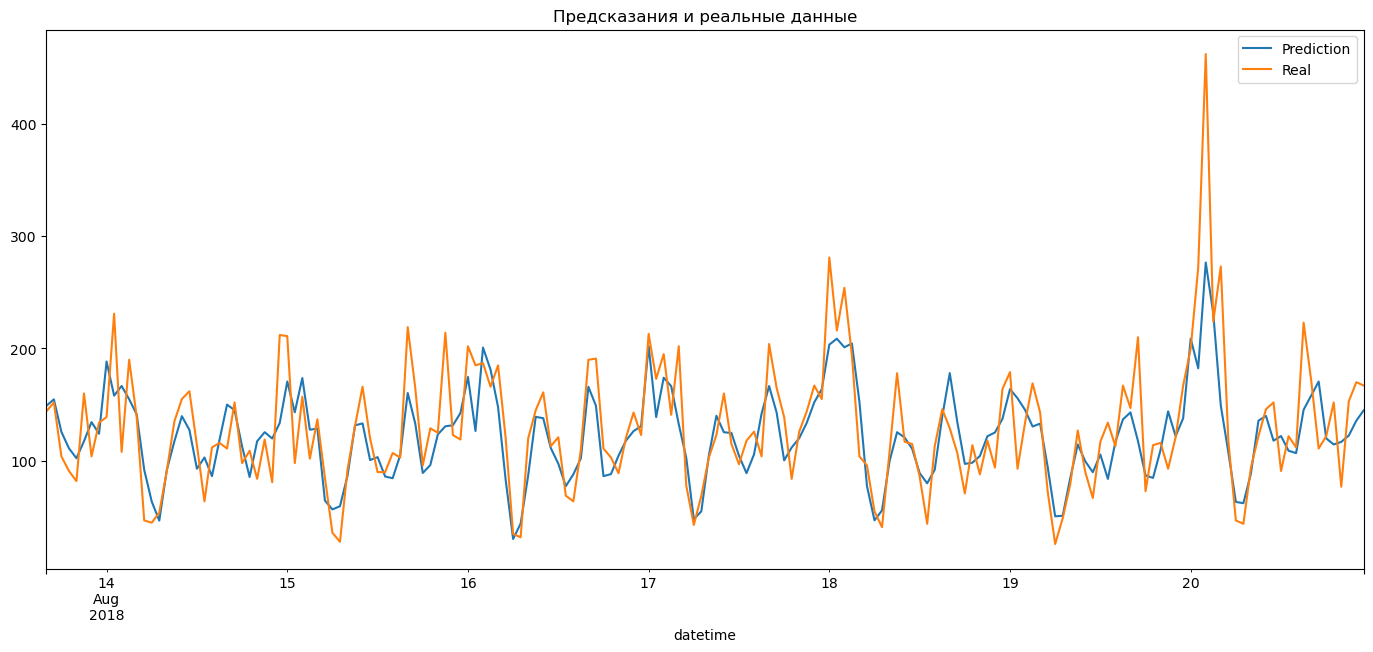

In [62]:
#визуализация предсказаний модели и реальных значений целевой функции
pd.DataFrame(cat_Grid.predict(X_test), index=y_test.index)['2018-08-13':'2018-08-20'].rename(columns={0: 'Prediction'}).plot(legend=True)

y_test.name = 'Real'
y_test['2018-08-13':'2018-08-20'].plot(figsize=(17, 7), legend=True, title='Предсказания и реальные данные');

## 6. Выводы

1. Данные были загружены и изучены. Было проведено ресемплирование данных по одному часу.
2. В данных были обработаны экстремальные значения.
3. Была изучена сезонность в данных.
4. Были созданы новые признаки на основании исторических данных -  на основании временного сдвига (до 24 ч) и на основании скользящих средних.
5. Выборка была поделена на обучающую и тестовую выборки в соотношении 9/1.
6. Были обучены модели машинного обучения, подобраны их гиперпараметры. Модели были протестированы кросс-валидацией с делением по временному ряду.
7. На основании этого была отобрана лучшая модель машинного обучения Catboost и протестирована на тестовых данных. Метрика RMSE на тестовой выборке составила 39.489. Параметры лучшей модели Catboost{'depth': 6, 'iterations': 2000, 'l2_leaf_reg': 1, 'learning_rate': 0.03, 'min_child_samples': 1}